# MSDS686 Final Kaggle Project

## Project Overview

The purpose of this project is to build a Neural Network to accuractely predict the classification of a kaggle dataset. The tuning done on this dataset was done specifically for the [Moltean Fruits](https://www.kaggle.com/moltean/fruits) dataset, but by following the steps in line with the code below, and tweak hyperparameters accordingly this notebook could be used to run any Kaggle dataset that has the following layout:

A training Dataset

A test Dataset

*If a validation Dataset already exists, the train_gen and validation_gen will need to be modified accordingly

Prior to accessing the Kaggle API it is necessary to go to one's account on Kaggle, and generate a token. This downloads a json file that can then be uploaded into this notebook to access the Kaggle datasets

**If used on another dataset, please follow the inline comments to adjust for information specific to that dataset (i.e. input shape, directory names, etc.)*

## Fruits 360

The [Moltean Fruits](https://www.kaggle.com/moltean/fruits) dataset analyzed in this specific project is made up of 131 classes of different fruit varieties. The data is split into 75% training and 25% test, and then the train dataset is further reduced into a train and validation set of 80% train and 20% validation. To see a sample of the data images and labels see the "Data Sample" section.

## Conclusion

The project used two models, one Convolutional Network built from scratch, and the prebuilt Xception model with no changes made. 

The models perform very similarly from both an effeciency and accuracy perspective, with the built from scratch model performing slightly more accurately

# Set up Notebook Enviornment

The required libraries, and definitions required to load data, plot samples of dataset, and plot model performance can be found below.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#!pip install -q kaggle This only needs to be run once per environment
from google.colab import files
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, optimizers, regularizers, initializers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import Xception

import random

In [3]:
def rand10_images(directory):
    images = []
    for dirs in os.listdir(directory):
        full_path = os.path.join(train_dir, dirs)
        for image in os.walk(full_path):
            images.append(os.path.join(full_path, image[2][1]))
    
    rand10 = random.choices(images, k=10)
    
    plotable_images = []
    labels = []
    for image in rand10:
        viewable_image = load_img(image)
        plotable_images.append(img_to_array(viewable_image))
        labels.append(os.path.split(os.path.split(image)[0])[1])

    print('The shape of the data is:', plotable_images[1].shape)

    fig, axs = plt.subplots(2,5, figsize = (15,5))
    axs[0,0].imshow(plotable_images[0]/255)
    axs[0,0].set_title(labels[0])
    axs[0,1].imshow(plotable_images[1]/255)
    axs[0,1].set_title(labels[1])
    axs[0,2].imshow(plotable_images[2]/255)
    axs[0,2].set_title(labels[2])
    axs[0,3].imshow(plotable_images[3]/255)
    axs[0,3].set_title(labels[3])
    axs[0,4].imshow(plotable_images[4]/255)
    axs[0,4].set_title(labels[4])
    axs[1,0].imshow(plotable_images[5]/255)
    axs[1,0].set_title(labels[5])
    axs[1,1].imshow(plotable_images[6]/255)
    axs[1,1].set_title(labels[6])
    axs[1,2].imshow(plotable_images[7]/255)
    axs[1,2].set_title(labels[7])
    axs[1,3].imshow(plotable_images[8]/255)
    axs[1,3].set_title(labels[8])
    axs[1,4].imshow(plotable_images[9]/255)
    axs[1,4].set_title(labels[9])
    [axi.set_axis_off() for axi in axs.ravel()]
    plt.show()
    
    num_classes = 0
    for dirs in os.listdir(train_dir):
        num_classes += 1
    print('There are {} classes in the dataset'.format(num_classes))
    return 


In [4]:
def data_distribution(directory):
    
    labels = []
    freq = []

    for dirs in os.listdir(directory):
        full_path = os.path.join(directory, dirs)
        labels.append(dirs)
        for image in os.walk(full_path):
            freq.append(len(image[2]))
    
    d = {'Label': labels, 'Frequency': freq}

    df = pd.DataFrame(d)

    df = df.sort_values(by = 'Label')

    print(len(df))

    distr = px.bar(df, x = 'Label', y = 'Frequency')
    
    return distr


In [5]:
def plot_scores(history):
    hist = pd.DataFrame(history.history)
    epochs = range(len(hist+1))

    plt.plot(epochs, hist['accuracy'], 'bo', label = 'accuracy')
    plt.plot(epochs, hist['val_accuracy'], 'b', label = 'validation_accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, hist['loss'], 'ro', label = 'loss')
    plt.plot(epochs, hist['val_loss'], 'r', label = 'validation_loss')
    plt.legend()
    plt.show()

    return

In [6]:
def model_evaluation(model_name, generator):
    results = model_name.evaluate(generator, verbose = 0)
    print('The loss of the model was:', results[0])
    print('The accuracy of the model was:', results[1])

    pred = model_name.predict(generator)
    y_pred = np.argmax(pred, axis = 1)

    cf = confusion_matrix(generator.classes, y_pred)
    heatmap = px.imshow(cf)


    heatmap.add_annotation(dict(font=dict(color="black",size=14),
                        x=.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

    heatmap.add_annotation(dict(font=dict(color="black",size=14),
                        x=-.10,
                        y=.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

    heatmap.add_annotation(dict(font=dict(color="black",size=18),
                        x=.5,
                        y=1.1,
                        showarrow=False,
                        text="Classes vs Predictions",
                        xref="paper",
                        yref="paper"))

    return heatmap

#Kaggle Enviornment
Below the Kaggle environment is created. This section uploads the token for the api, lists a handful of datasets (For this analysis datasets with "Fruits" included in the title are selected), and finally the data is downloaded and unzipped.

In [7]:
#upload kaggle.json to access API
files.upload()
;

Saving kaggle.json to kaggle.json


''

In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list -s Fruits
;

ref                                                    title                                               size  lastUpdated          downloadCount  
-----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
moltean/fruits                                         Fruits 360                                         760MB  2020-05-18 10:35:15          56705  
mjamilmoughal/fruits-with-colors-dataset               Fruits with colors dataset                          816B  2018-01-13 10:22:33           7099  
sriramr/fruits-fresh-and-rotten-for-classification     Fruits fresh and rotten for classification           4GB  2018-08-24 15:05:40           3507  
chrisfilo/fruit-recognition                            Fruit Recognition                                    8GB  2020-02-04 18:52:00           3193  
raghu07/vegetable-and-fruits-price-in-india            Daily Vegetable and Fruits Prices data  2010-

''

In [9]:
! kaggle datasets download moltean/fruits

 98% 745M/760M [00:06<00:00, 127MB/s]
100% 760M/760M [00:06<00:00, 118MB/s]


In [10]:
!unzip -qq fruits.zip

# Data Sample

Below shows the variety of Fruits present in this dataset, along with the distribution of classifications in the training dataset.

In [11]:
train_dir = 'fruits-360/Training' #using another dataset, this directory may be labeled slightly different
test_dir = 'fruits-360/Test' #using another dataset, this directory may be labeled slightly different

The shape of the data is: (100, 100, 3)


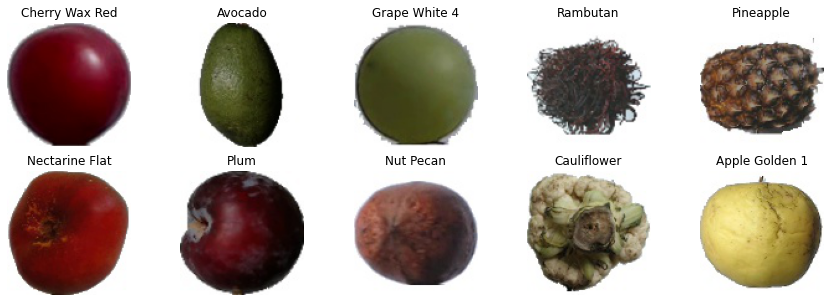

There are 131 classes in the dataset


In [12]:
rand10_images(train_dir)

In [13]:
data_distribution(train_dir)

131


In [14]:
data_distribution(test_dir)

131


# Methodology and Application

With a general understanding of the data, and the distributions between the training and test data, the generators can now be established and the models built. For this study, convolutional networks are necessary as the image data will be much better predicted using convolutional network opposed to a simple network with dense layers. Two models were built and analyzed for the fruits dataset:

1. The first model is built from scratch using the functional API to make a model with two split layers, one of three branches and one of two.

2. The second model is the Xception model out of the box with no additional parameters added to see how it opperates.

Once the models have ran, they will be analyzed on both the validation and test data, before finally determining which is more optimal. 

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split = .2)
test_datagen = ImageDataGenerator(rescale=1./255)

epoch = 20

In [16]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size = 20,
    class_mode = 'categorical',
    subset = 'training'
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size = 20,
    class_mode = 'categorical',
    subset = 'validation'
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = (100, 100),
    shuffle = False,
    batch_size = 20,
    class_mode = 'categorical'
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


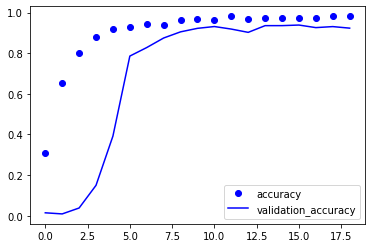

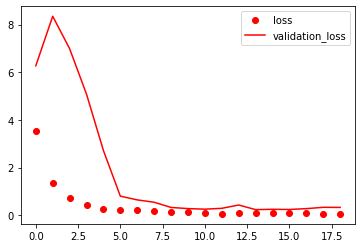

In [17]:
backend.clear_session()

visible = Input(shape=(100,100,3))

#start
x = Conv2D(32, 3, padding = 'same', activation = 'relu')(visible)
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2,2), padding = 'same')(x)


#model = Model(inputs = visible, outputs = x)

#model.summary()
#Block 1
block1 = Conv2D(64, 3, padding = 'same', 
                activation = 'relu', 
                kernel_initializer='he_uniform')(x)
block1 = BatchNormalization()(block1)
block1 = Conv2D(64, 3, padding = 'same', 
                activation = 'relu', 
                kernel_initializer='he_uniform')(block1)
block1 = BatchNormalization()(block1)
block1 = Conv2D(64, 3, padding = 'same', 
                activation = 'relu', 
                kernel_initializer='he_uniform')(block1)
block1 = BatchNormalization()(block1)
block1 = Dropout(.2)(block1)
block1 = MaxPooling2D((2,2), padding = 'same')(block1)

#Block 2
block2 = Conv2D(64, 1, strides = (2,2), padding = 'same', 
                activation = 'relu')(x)
block2 = BatchNormalization()(block2)

#Block 3
block3 = Conv2D(64, 5, padding = 'same', 
                activation = 'relu')(x)
block3 = BatchNormalization()(block3)
block3 = Conv2D(64, 5, padding = 'same', 
                activation = 'relu')(block3)
block3 = BatchNormalization()(block3)
block3 = Dropout(.2)(block3)
block3 = AveragePooling2D((2,2), padding = 'same')(block3)

#Block 4
x = layers.add([block1, block2, block3])

#Block 5
block5 = Conv2D(128, 3, padding = 'same', 
                activation = 'relu',
                kernel_initializer='he_uniform')(x)
block5 = BatchNormalization()(block5)
block5 = Conv2D(128, 3, padding = 'same', 
                activation = 'relu',
                kernel_initializer='he_uniform')(block5)
block5 = BatchNormalization()(block5)
block5 = Conv2D(128, 3, padding = 'same', 
                activation = 'relu',
                kernel_initializer='he_uniform')(block5)
block5 = BatchNormalization()(block5)
block5 = Dropout(.2)(block5)
block5 = MaxPooling2D((2,2), padding = 'same')(block5)

#Block 6
block6 = Conv2D(128, 1, strides = (2,2), padding = 'same', 
                activation = 'relu')(x)
block6 = BatchNormalization()(block6)

#Block 7 and Flatten
x = layers.add([block5, block6])
x = Flatten()(x)

#Hidden Dense layers and Output
x = Dense(512, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(131, activation = 'softmax')(x)

model = Model(inputs = visible, outputs = x)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = .0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(
    train_gen,
    steps_per_epoch = 100,
    epochs = epoch,
    validation_data = validation_gen,
    verbose = 0,
    callbacks = [EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights=True)]
)

plot_scores(history)



In [18]:
model_evaluation(model, test_gen)

The loss of the model was: 0.2904401421546936
The accuracy of the model was: 0.9279354810714722


83689472/83683744 [==============================] - 2s 0us/step


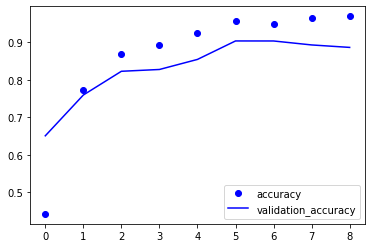

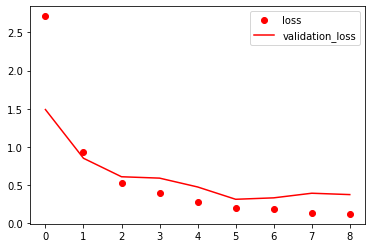

In [20]:
backend.clear_session()
base_model = Xception(weights = 'imagenet',
                      include_top = False,
                      input_shape = (100,100,3)
                      )

base_model.trainable = False 

modelXception = models.Sequential()
modelXception.add(base_model)
modelXception.add(layers.Flatten())
modelXception.add(layers.Dense(512, activation = 'relu'))
modelXception.add(layers.Dense(131, activation = 'softmax'))

modelXception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = .0001),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

Xceptionhistory = modelXception.fit(train_gen,
                                    steps_per_epoch = 100,
                                    epochs = epoch,
                                    validation_data = validation_gen,
                                    verbose = 0,
                                    callbacks = [EarlyStopping( monitor = 'val_accuracy', patience = 3, restore_best_weights = True)])
plot_scores(Xceptionhistory)

In [21]:
model_evaluation(modelXception, test_gen)

The loss of the model was: 0.5514375567436218
The accuracy of the model was: 0.8547690510749817


From both the accuracy scores of the test data, along with the heatmaps it can be seen the model from scratch performs better on almost every level. The accuracy is roughly 6% better, and the heatmap shows less frequent misclassification, and even some brighter areas. This suggests the above model is mostly struggling with a few classes, opposed to incorrectly classifying many classes. Analyzing what those classes are may help either reduce/combine them (if Red Apple 1 and Red Apple 2 are the big issues for example) or help guide how to better refine the model.